In [1]:
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 6]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
#     .cache()
)
df.printSchema()
# df.show()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [4]:
pdf = (
    df
    .select(f.explode("hits").alias("h"))
    .select(
        f.col("h.t").alias("t"),
        f.col("h.x").alias("x"),
        f.col("h.y").alias("y"),
    )
    .toPandas()
)
pdf.head()

,t,x,y
0,805.186457,-3.410069,-2.075715
1,926.205980,4.763139,28.911008
2,1013.461017,-22.692024,-13.571205
3,1455.289515,1.290518,0.833531
4,2311.770348,2.549458,17.510870


In [5]:
with open("Any aqs; Config.yaml", "r") as fp:
    info = safe_load(fp)

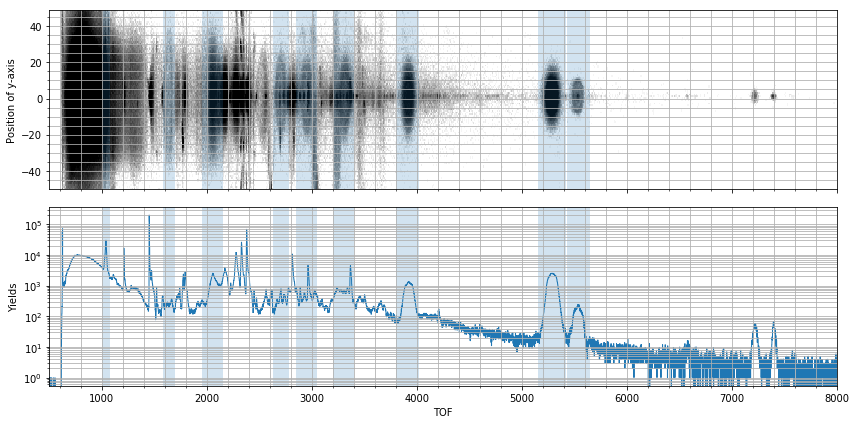

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.xlabel("TOF")
plt.ylabel("Position of y-axis")
plt.hist2d(
    pdf["t"],
    pdf["y"],
    bins=(np.arange(500, 8000, 5),
          np.arange(-50, 50, 1)),
    cmap="Greys",
    norm=LogNorm(),
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
plt.xlim(500, 8000)
plt.clim(2e0, 2e2)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(212)
plt.xlabel("TOF")
plt.ylabel("Yields")
plt.hist(
    pdf["t"],
    bins=np.arange(500, 8000, 1),
    histtype="step",
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
plt.xlim(500, 8000)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.tight_layout()
plt.show()

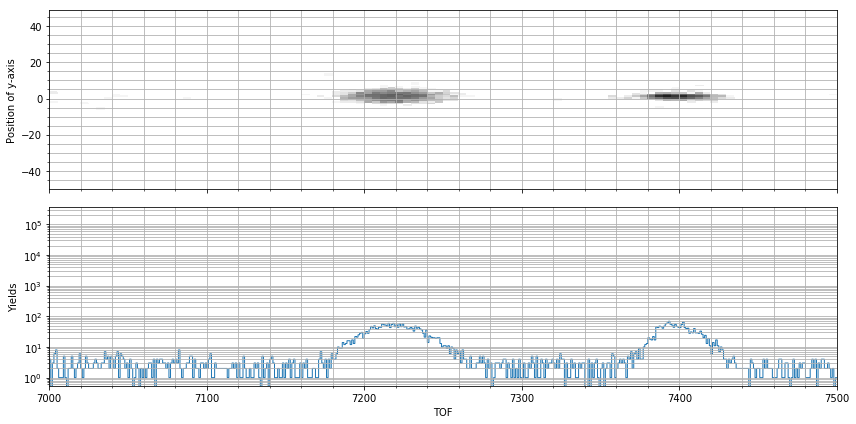

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.xlabel("TOF")
plt.ylabel("Position of y-axis")
plt.hist2d(
    pdf["t"],
    pdf["y"],
    bins=(np.arange(500, 8000, 5),
          np.arange(-50, 50, 1)),
    cmap="Greys",
    norm=LogNorm(),
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
plt.xlim(7000, 7500)
plt.clim(2e0, 2e2)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(212)
plt.xlabel("TOF")
plt.ylabel("Yields")
plt.hist(
    pdf["t"],
    bins=np.arange(500, 8000, 1),
    histtype="step",
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
plt.xlim(7000, 7500)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.tight_layout()
plt.show()

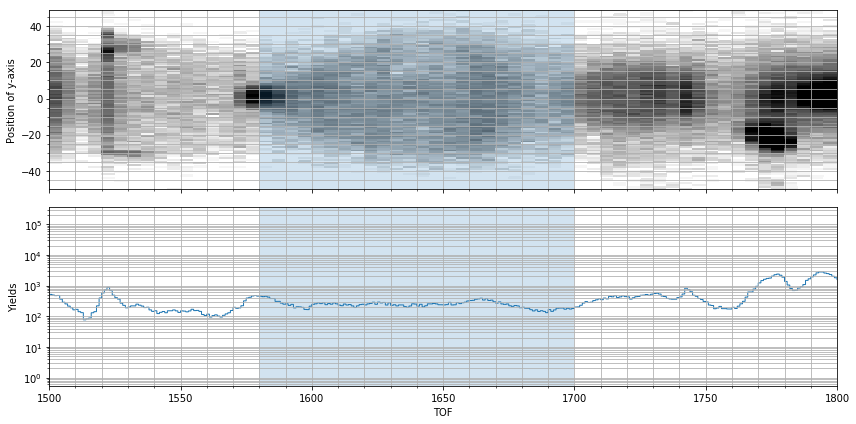

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.xlabel("TOF")
plt.ylabel("Position of y-axis")
plt.hist2d(
    pdf["t"],
    pdf["y"],
    bins=(np.arange(500, 8000, 5),
          np.arange(-50, 50, 1)),
    cmap="Greys",
    norm=LogNorm(),
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
# plt.xlim(500, 8000)
plt.xlim(1500, 1800)
plt.clim(2e0, 2e2)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(212)
plt.xlabel("TOF")
plt.ylabel("Yields")
plt.hist(
    pdf["t"],
    bins=np.arange(500, 8000, 1),
    histtype="step",
)
for k, d in info["momentum_analyzer"]["models"].items():
    plt.axvspan(d["fr"], d["to"], alpha=0.2)
# plt.xlim(500, 8000)
plt.xlim(1500, 1800)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.tight_layout()
plt.show()